In [1]:
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
from skimage import exposure
import random
import sys

In [2]:
im1 = np.array(Image.open('band1.gif', 'r'))
im2 = np.array(Image.open('band2.gif', 'r'))
im3 = np.array(Image.open('band3.gif', 'r'))
im4 = np.array(Image.open('band4.gif', 'r'))

In [3]:
def euclidean_dist(x1,x2):
    dist = sum([(a - b) ** 2 for a, b in zip(x1, x2)])**0.5
    return dist


def clustering(k,imageinput,centroids):
    min_dist = sys.maxsize

    classData = np.zeros((512,512))

    for i in range(512):
        for j in range(512):
            for x in range(k):
                distance = euclidean_dist(imageinput[:,i,j],centroids[x])

                if(min_dist > distance):
                    min_dist = distance
                    label = x

            classData[i][j] = label
            min_dist = sys.maxsize
    
    return classData

def updateCentroids(imageinput,classData):
    sums =[0,0,0,0]
    total = 0
    updatedCentroids = np.zeros((k,4))

    for x in range (k):
        for i in range(512):
            for j in range(512):
                if classData[i][j] == x:
                    sums = np.array(sums) + imageinput[:,i,j]
                    total+=1
        sums = sums/total
        updatedCentroids[x] = sums
        sums = [0,0,0,0]
        total = 0
    return updatedCentroids

In [4]:
 color = [[255,0,0],[0,255,0],[0,0,255],[0,255,255],[255,255,0]] 

In [5]:
k=2

In [6]:
# 2. Input satellite images, imageInput (512, 512,4)

imageinput=np.array([im1,im2,im3,im4])
print(imageinput.reshape(512,512,4).shape)
print(imageinput[0][0].shape)


(512, 512, 4)
(512,)


In [7]:
# 3. Initialize clusteredImage as the output image
clusteredImage = np.zeros((512,512,3))

In [8]:
# 4. Select k random x,y co-ordinates and extract pixel values from imageInput 

coord = np.array(([300,100],[200,300],[200,400],[100,72],[121,96]))

initCentroids = []
for i in range(k):
    initCentroids.append(imageinput[:,coord[i][0],coord[i][1]])

initCentroids = np.array(initCentroids)
print(initCentroids.shape)

# we will be updating centroids later
centroids = initCentroids


(2, 4)


In [9]:
print(centroids)

[[ 4  4  6 12]
 [11 13 16 19]]


### Step 5

In [10]:
### loop until stopping criteria is met
# at 11 matched
count = 0
while(count < 5):
    classData = clustering(k,imageinput,centroids)
    updatedCentroids = np.round(updateCentroids(imageinput,classData))
    if (centroids==updatedCentroids).all():
        print("matched")
        break
    else:
        centroids = updatedCentroids
    count+=1
    

<ipython-input-3-b5e2fed0f1aa>:2: RuntimeWarning: overflow encountered in ubyte_scalars
  dist = sum([(a - b) ** 2 for a, b in zip(x1, x2)])**0.5


In [11]:
# np.set_printoptions(threshold=sys.maxsize)
# print(classData)

In [12]:
print(updatedCentroids)

[[ 8.  9. 11. 18.]
 [11. 13. 17. 23.]]


### step 6

In [13]:
for i in range(512):
    for j in range(512):
        clusteredImage[i,j,:] = color[int(classData[i,j])]


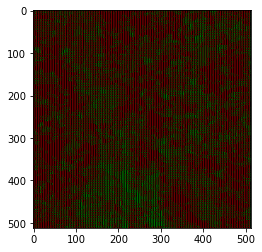

In [14]:
img = Image.fromarray(clusteredImage.astype(int), 'RGB')
imgplot = plt.imshow(img)
plt.show()

## Evaluation of clustering - silhouette coefficient 

In [39]:
def calSilhouette(p,classData,imageinput,k):
    
    total = 0
    distance = 0
    
    pixelValue = classData[p[0],p[1]]
    
    for i in range(512):
        for j in range(512):
            if classData[i][j] == pixelValue:
                distance += euclidean_dist(imageinput[:,i,j],imageinput[:,p[0],p[1]])
                total+=1               
    a = distance/total
    
    # distances of other cluster
    
    d = []
    for x in range(k):
        if x == pixelValue:
            continue
        else:
            total = 0
            distance = 0
            for i in range(512):
                for j in range(512):
                    if classData[i][j] == x:
                        distance += euclidean_dist(imageinput[:,i,j],imageinput[:,p[0],p[1]])
                        total+=1 
            
            if(total != 0):
                d.append(distance/total) 
            else:
                d.append(sys.maxsize)

    b = min(d)
    s = (b-a)/max(b,a)
    return s

### Initialize silhouette array s (512,512). 

In [16]:
s = np.zeros((512,512))

### For each pixel p in classData, sp = calSilhouette(p) 

In [17]:
# too heavy process, instead of 512 * 512, running it for 2 * 2
for i in range(2):
    for j in range(2):
        s[i][j] = calSilhouette([i,j],classData,imageinput,k)

<ipython-input-3-b5e2fed0f1aa>:2: RuntimeWarning: overflow encountered in ubyte_scalars
  dist = sum([(a - b) ** 2 for a, b in zip(x1, x2)])**0.5


### silhouette_coeff = max(s) 

In [18]:
silhouette_coeff_2 = np.amax(s) 
print(silhouette_coeff_2)

0.4817979184033032


## Repeating same process for k = 3,4,5

In [21]:
def kmeans(k,imageinput,coord,threshold):

    clusteredImage = np.zeros((512,512,3))
    initCentroids = []

    for i in range(k):
        initCentroids.append(imageinput[:,coord[i][0],coord[i][1]])

    initCentroids = np.array(initCentroids)

    # we will be updating centroids later
    centroids = initCentroids

    # loop until stopping criteria is met
    count = 0
    while(count < threshold):
        classData = clustering(k,imageinput,centroids)
        updatedCentroids = np.round(updateCentroids(imageinput,classData))
        if (centroids==updatedCentroids).all():
            print("same centroids")
            break
        else:
            centroids = updatedCentroids
        count+=1

    # form image
    for i in range(512):
        for j in range(512):
            clusteredImage[i,j,:] = color[int(classData[i,j])]

    img = Image.fromarray(clusteredImage.astype(int), 'RGB')
    imgplot = plt.imshow(img)
    plt.show()


### k = 3

<ipython-input-3-b5e2fed0f1aa>:2: RuntimeWarning: overflow encountered in ubyte_scalars
  dist = sum([(a - b) ** 2 for a, b in zip(x1, x2)])**0.5


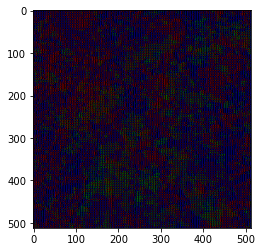

In [22]:
k = 3
kmeans(k,imageinput,coord,4)

In [40]:
# silloutte
s = np.zeros((512,512))
for i in range(2):
    for j in range(2):
        s[i][j] = calSilhouette([i,j],classData,imageinput,k)
silhouette_coeff_3 = np.amax(s) 


<ipython-input-3-b5e2fed0f1aa>:2: RuntimeWarning: overflow encountered in ubyte_scalars
  dist = sum([(a - b) ** 2 for a, b in zip(x1, x2)])**0.5


### k = 4

<ipython-input-3-b5e2fed0f1aa>:2: RuntimeWarning: overflow encountered in ubyte_scalars
  dist = sum([(a - b) ** 2 for a, b in zip(x1, x2)])**0.5


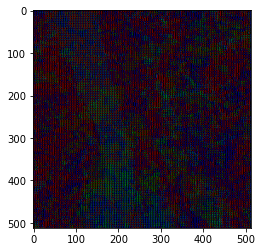

In [41]:
k = 4
kmeans(k,imageinput,coord,4)

In [42]:
# silloutte
s = np.zeros((512,512))
for i in range(2):
    for j in range(2):
        s[i][j] = calSilhouette([i,j],classData,imageinput,k)
silhouette_coeff_4 = np.amax(s) 

<ipython-input-3-b5e2fed0f1aa>:2: RuntimeWarning: overflow encountered in ubyte_scalars
  dist = sum([(a - b) ** 2 for a, b in zip(x1, x2)])**0.5


### k = 5

<ipython-input-3-b5e2fed0f1aa>:2: RuntimeWarning: overflow encountered in ubyte_scalars
  dist = sum([(a - b) ** 2 for a, b in zip(x1, x2)])**0.5


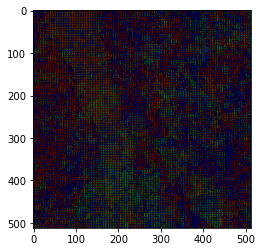

In [43]:
k = 5
kmeans(k,imageinput,coord,4)

In [44]:
# silhouette
s = np.zeros((512,512))
for i in range(2):
    for j in range(2):
        s[i][j] = calSilhouette([i,j],classData,imageinput,k)
silhouette_coeff_5 = np.amax(s) 

<ipython-input-3-b5e2fed0f1aa>:2: RuntimeWarning: overflow encountered in ubyte_scalars
  dist = sum([(a - b) ** 2 for a, b in zip(x1, x2)])**0.5


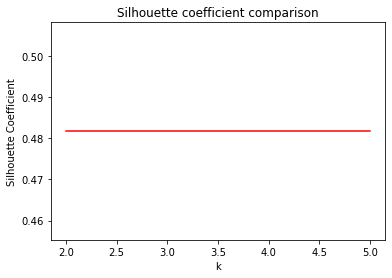

In [45]:
### Silhouette coefficient comparison
plt.plot([2,3,4,5], [silhouette_coeff_2,silhouette_coeff_3,silhouette_coeff_4, silhouette_coeff_5], color ="red")  
plt.title("Silhouette coefficient comparison")  
plt.xlabel("k")  
plt.ylabel("Silhouette Coefficient") 
plt.show()